In [2]:
import pypsa
import numpy as np
import os
import sys
import re
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from pathlib import Path

sys.path.append(str(Path.cwd() / ".." / "scripts"))

from make_egs_plots import plot_timeseries, plot_geothermal_map, get_network_data

model_name = "elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc"
dir_template = "egs_sweep_{}"

In [3]:
costs_2_evaluate = np.arange(100000, 555000, 5000)

energies, capacities, costs_list = list(), list(), list() 
capital_cost_steps = list()

for i, costs in enumerate(costs_2_evaluate):

    model_path = Path.cwd() / dir_template.format(int(costs)) / "postnetworks" / model_name

    try:
        n = pypsa.Network(model_path)
    except FileNotFoundError:
        continue

    # capcost = re.sub("[^0-9]", "", ex)
    print("+========================== Capital Cost {} ================================".format(costs))
    print(model_path)

    cost, cap, energy = plot_geothermal_map(n, "AC", return_data=True)
    print("before: ")
    print(energy.shape)
    print(cap.shape)
    print(cost.shape)
    print(energy.head())
    print("======================================================================")
    cost, cap, energy = get_network_data(n, "AC")
    print("after: ")
    print(energy.shape)
    print(cap.shape)
    print(cost.shape)
    print(energy.head())

    sys.exit()

    energies.append(energy)    
    capacities.append(cap)    
    costs_list.append(cost)    
    capital_cost_steps.append(costs)
    # plot_timeseries(n, "all", "AC")

    if i == 1:
        break

INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


+========================== Capital Cost 100000 ================================
/mnt/c/Users/s2216495/Desktop/pypsa/my_pypsa_eur_sec/pypsa-eur-sec/results/egs_sweep_100000/postnetworks/elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc
before: 
(37, 14)
(37, 14)
(37, 14)
after: 
(37, 14)
(37, 14)
(37, 14)


SystemExit: 

In [3]:
from vresutils.costdata import annuity

an = annuity(30, 0.07)

def capex_to_cc(capex, lt, dr):
    """ad-hoc equation"""
    return annuity(lt, dr) * capex + 0.02*capex

def cc_to_capex(cc, lt, dr):
    return cc / (0.02 + annuity(lt, dr))

capex_to_cc(cc_to_capex(1, 30, 0.07), 30, 0.07)

0.9999999999999999

In [6]:
import pandas as pd
capacities_df = pd.concat(capacities, axis=1)
capacities_df.columns = capital_cost_steps

# capacities_df.to_csv("capacities_europe.csv")

In [7]:
import pandas as pd
import numpy as np

capex = pd.Series(cc_to_capex(np.array(capital_cost_steps), 30, 0.07))
country_shares = pd.DataFrame(index=energies[0].groupby(level=0).sum().index.tolist() + ["EU"])

for costs, df in zip(capital_cost_steps, energies):

    idx = pd.IndexSlice
    gt = df.loc[idx[:, "geothermal heat"]]

    totals = df.groupby(level=0).sum()
    totals = pd.concat((totals, pd.Series({"EU": totals.sum()})))
    
    diff = totals.drop(index=["EU"]).index.difference(gt.index)
    gt = pd.concat((
        gt, 
        pd.Series(np.zeros_like(diff), index=diff), 
        pd.Series({"EU": gt.sum()})))

    percentages = gt.divide(totals)

    country_shares[costs] = percentages


country_shares.to_csv("country_shares.csv")
totals.to_csv("total_energies.csv")
capex.to_csv("capex.csv")

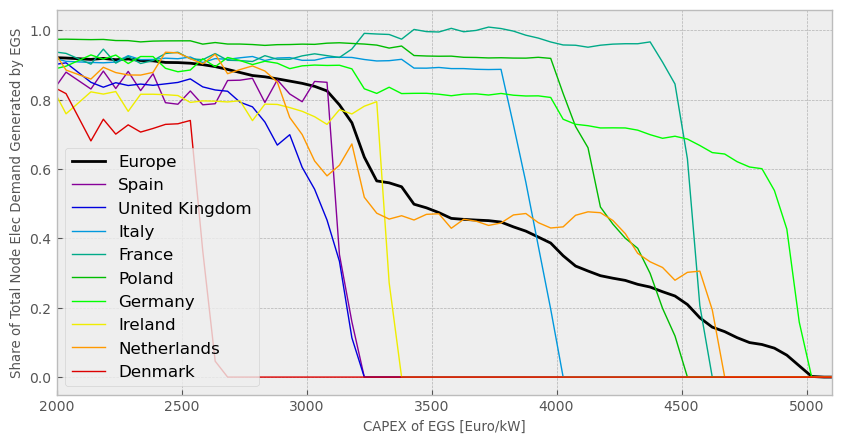

In [13]:
import pycountry
import matplotlib.pyplot as plt
plt.style.use("bmh")

country_mapper = {country.alpha_2: country.name for country in pycountry.countries}
country_mapper["EU"] = "Europe"

n_show = 10

show_countries = totals.sort_values(ascending=False).iloc[:n_show].index 

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# viridis, plasma, inferno, magma, cividis, cool, winter, copper, gist_earth, turbo

colormap = plt.cm.nipy_spectral #I suggest to use nipy_spectral, Set1,Paired
ax.set_prop_cycle("color", [colormap(i) for i in np.linspace(0, 1, n_show+1)])


# x = country_shares.columns.values.astype(float)
x = capex.values * 1e-3

for country in country_shares.loc[show_countries].index:
    
    if country == "EU":
        linewidth = 2. 
    else:
        linewidth = 1. 
        
    ax.plot(x,
            country_shares.loc[country].values,
            label=country_mapper[country[:2]],
            linewidth=linewidth, 
            ) 

ax.set_xlabel("CAPEX of EGS [Euro/kW]")
ax.set_ylabel("Share of Total Node Elec Demand Generated by EGS")
ax.legend()

ax.set_xlim(2e3, 5.1e3)

ax.set_title("")

plt.show()

In [10]:
ov = pd.read_csv(Path.cwd() / ".." / "resources" / "egs_test" / "egs_overlap_matrix_s_37.csv", index_col=0)
pot_2015 = pd.read_csv(Path.cwd() / ".." / "resources" / "egs_potentials_by_year" / "egs_potentials_s_37_2015.csv")

gdf = gpd.GeoDataFrame(pot_2015.drop(columns=["geometry", "dh_share.1"]), geometry=gpd.GeoSeries.from_wkt(pot_2015.geometry))
gdf.index = pot_2015.geometry


gdf.head()

NameError: name 'gpd' is not defined

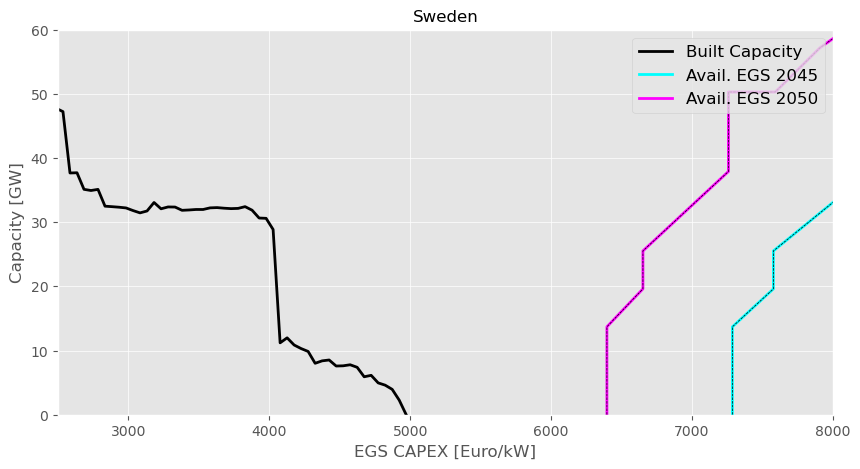

In [11]:
import numpy as np
import pycountry
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

network_file = "../resources/egs_test/regions_onshore_elec_s_37.geojson"
network_regions = gpd.read_file(network_file).set_crs(epsg=4326)
network_regions.index = network_regions["name"]

cap_df = pd.read_csv("capacities_europe.csv").rename(columns={"Unnamed: 0": 'node'})

def get_region_capex_pnom(region_name, year):


    # prepare year egs data
    egs_data = pd.read_csv(Path.cwd() / 
                           ".." / 
                           "resources" / 
                           "egs_potentials_by_year" / 
                           f"egs_potentials_s_37_{year}.csv")
    egs_data_gdf = gpd.GeoDataFrame(egs_data.drop(columns=["geometry", "dh_share.1"]),
                           geometry=gpd.GeoSeries.from_wkt(egs_data.geometry))


    if not region_name == "EU":
        # prepare node geometry
        region_geom = network_regions.geometry.loc[region_name]

        overlap = egs_data_gdf.geometry.apply(lambda geom: geom.intersection(region_geom).area)
        overlap = overlap.loc[overlap > 0.]

        if overlap.empty:
            return pd.DataFrame(columns=["capex", "p_nom_max"])
            
        egs_data = egs_data.loc[overlap.index]
        p_noms = egs_data["p_nom_max"].multiply(overlap)

    else:    
        p_noms = egs_data["p_nom_max"]

    capexes = egs_data["CAPEX"] * 1e3
    result = (
        pd.DataFrame({
            "capex": capexes,
            "p_nom_max": p_noms,
        })
        .sort_values(by="capex", ascending=True)
    )
    result["p_nom_max"] = result['p_nom_max'].cumsum()

    return result
    
# country_shares.to_csv("country_shares.csv")
# totals.to_csv("total_energies.csv")

def make_country_summary(node):
    years = np.arange(2015, 2055, 5)

    # shares = pd.read_csv("country_shares.csv", index_col=0).loc[node]
    # total_energy = pd.read_csv("total_energies.csv", index_col=0).loc[node]

    if node == "EU":
        gt = cap_df.drop(columns=["node"])
        gt = gt.loc[gt.carrier == "geothermal heat"].drop(columns=["carrier"]).sum()
    
    else:
        subset_cap = cap_df.loc[cap_df.node == node].drop(columns=["node"])
        total_cap = subset_cap.drop(columns=["carrier"]).sum()
        gt = subset_cap.loc[subset_cap.carrier == "geothermal heat"].drop(columns=["carrier"])

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    try:
        x = cc_to_capex(np.array(gt.columns).astype(float), 30, 0.07)
    except AttributeError:
        x = cc_to_capex(np.array(gt.index).astype(float), 30, 0.07)
    ax.plot(x*1e-3,
            gt.values.flatten() * 1e-3,
            linewidth=2.,
            label="Built Capacity",
            color="k",
            )

    ax.legend()
    ax.set_xlabel("EGS CAPEX [Euro/kW]")
    ax.set_ylabel("Capacity [GW]")
    
    if node in good_xlims:
        ax.set_xlim(good_xlims[node])
        ax.set_ylim(good_ylims[node])

    # viridis, plasma, inferno, magma, cividis, cool, winter, copper, gist_earth, turbo
    colormap = plt.cm.cool #I suggest to use nipy_spectral, Set1,Paired
    
    num_colors = 0

    for year in years:
        data = get_region_capex_pnom(node, year)
        if data.empty:
            continue

        x, y = data["capex"].values * 1e-3, data["p_nom_max"].values

        if node in good_xlims:
            if x[0] > good_xlims[node][1] or x[-1] < good_xlims[node][0]:
                continue
        num_colors += 1

    ax.set_prop_cycle("color", [colormap(i) for i in np.linspace(0, 1, num_colors)])

    for year in years:
        data = get_region_capex_pnom(node, year)
        if data.empty:
            continue

        x, y = data["capex"].values * 1e-3, data["p_nom_max"].values.tolist()
        x = x.tolist()

        if node in good_xlims:
            if x[0] > good_xlims[node][1] or x[-1] < good_xlims[node][0]:
                continue
        
        if y[0] > 0:
            y = [0.] + y
            x = [x[0]] + x

        if len(x) == 1:
            ax.scatter(x, y, s=30, label=f"Avail. EGS {year}", )
            continue

        ax.plot(x, y, label=f"Avail. EGS {year}", linewidth=2.)
        ax.plot(x, y, linestyle="--", linewidth=0.5, color="k")
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(loc='upper right')

    if node != "EU":
        country = pycountry.countries.get(alpha_2=node[:2]).name
    else:
        country = "Europe" 

    # ax.set_title(f"{country}; EGS built by PyPSA-Eur vs EGS Potential Estimated in Aghahosseini, Breyer 2020", fontsize=12)
    ax.set_title(f"{country}")
    plt.show()


good_xlims = {
    "DE1 0": (0.22e4, 0.5e4),
    "SE2 0": (0.25e4, 0.8e4),
    "EU": (0.1e4, 0.55e4),

}
good_ylims = {
    "DE1 0": (0., 350),
    "SE2 0": (0., 60),
    "EU": (0., 1200),
}

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
BIGGEST_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title


# def get_region_capex_pnom(region_name, year):

# get_region_capex_pnom("AT1 0", 2030)
make_country_summary("SE2 0")
# make_country_summary("DE1 0")
# make_country_summary("EU")


In [1]:
import pypsa
import numpy as np
import os
import sys
import re
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from pathlib import Path

sys.path.append(str(Path.cwd() / ".." / "scripts"))

from make_egs_plots import plot_timeseries, plot_geothermal_map

model_name = "elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc"
dir_template = "egs_sweep_{}"

INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


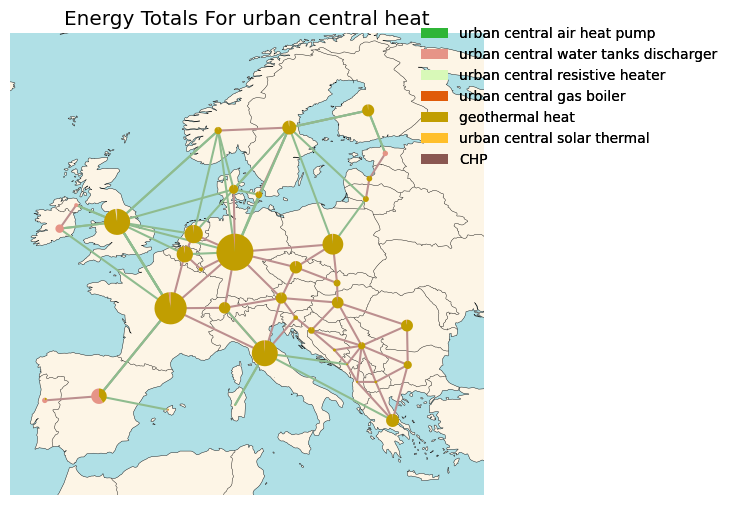

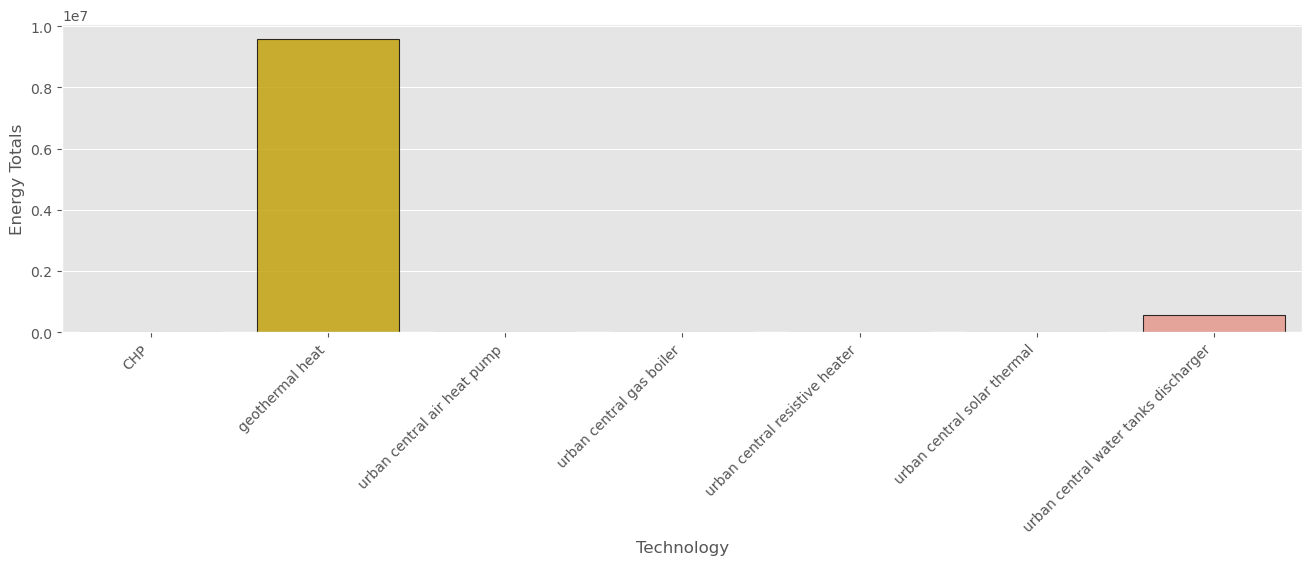

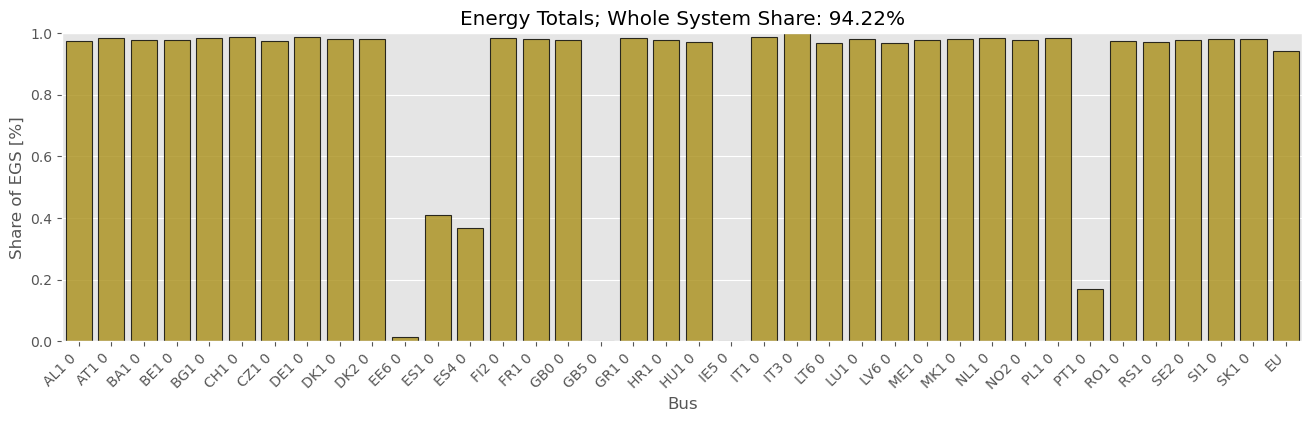

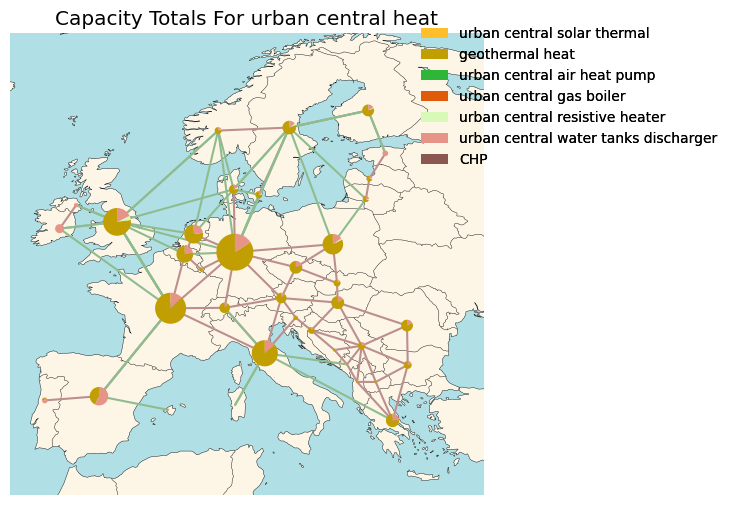

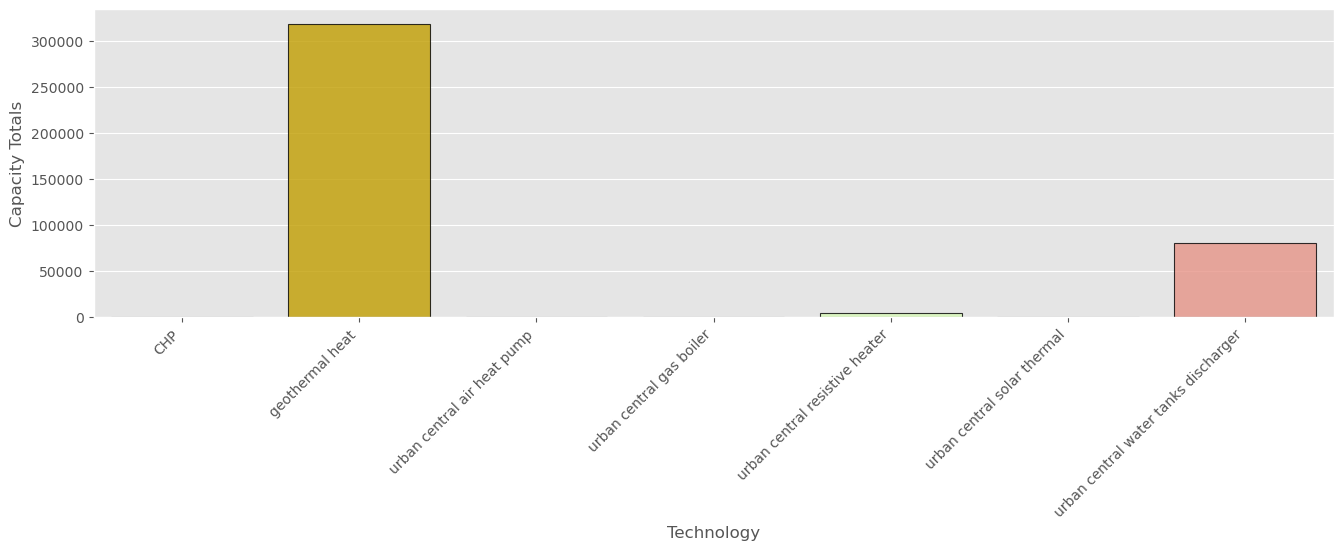

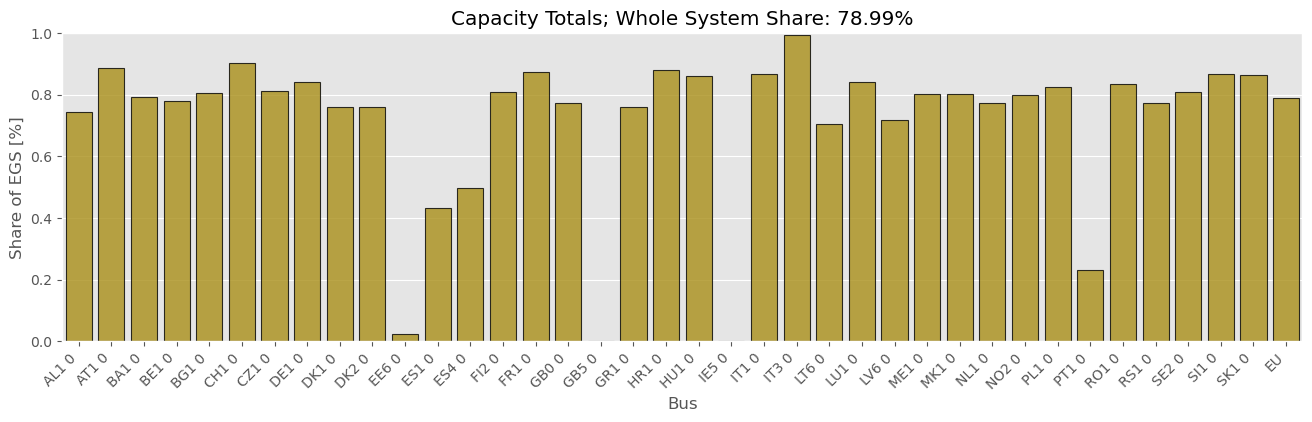

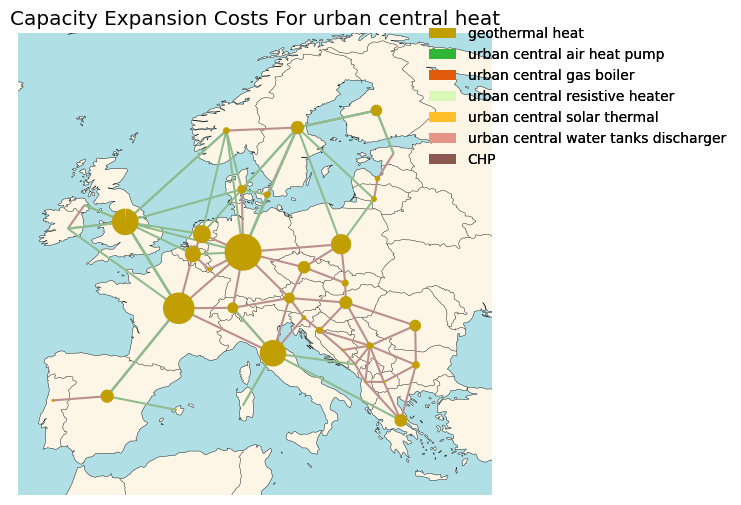

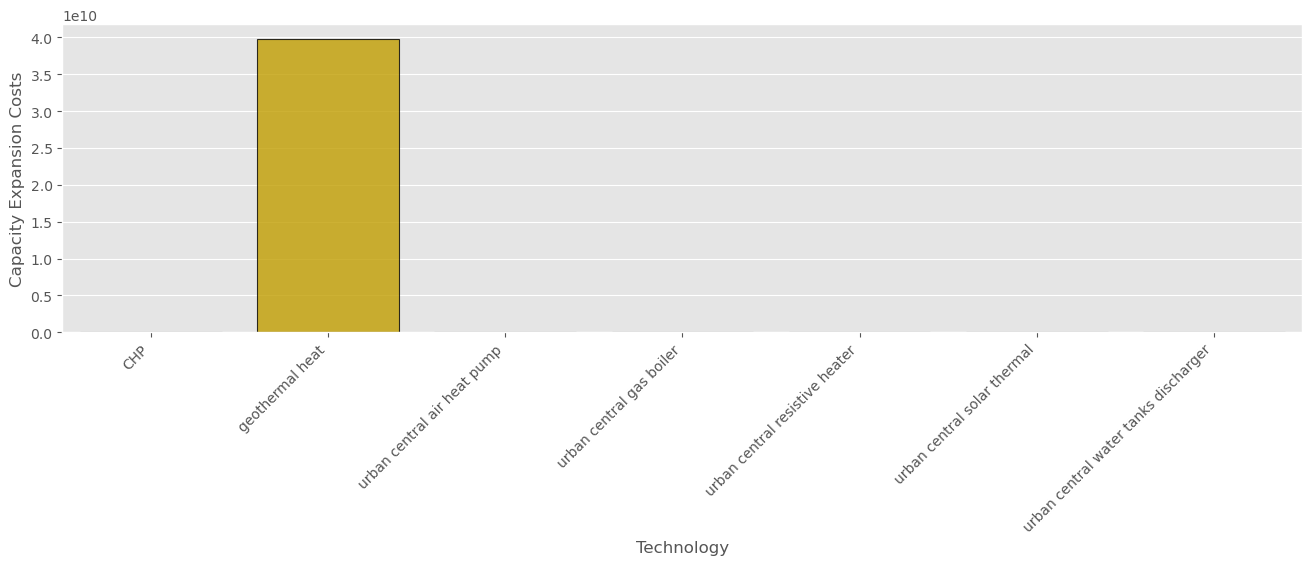

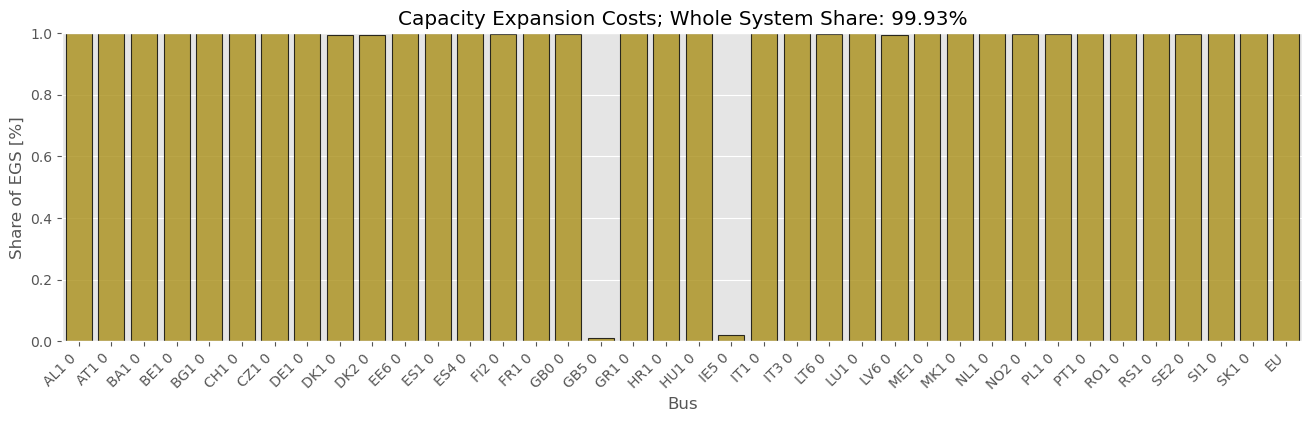

In [2]:
model_path = Path.cwd() / "egs_district_heating_sweep_100000" / "postnetworks" / model_name
n = pypsa.Network(model_path)

# plot_geothermal_map(n, "AC", do_plot=True)
plot_geothermal_map(n, "urban central heat", do_plot=True)

In [5]:
import pandas as pd

a = pd.DataFrame(np.zeros((3,3)), index=[1,2,3], columns=["a", "b", "c"])

a.iloc[:,0] = np.ones(len(a))
a

,a,b,c
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0


##### Geothermal Map

In [150]:
print(network_regions.head())


overlap_matrix = pd.DataFrame(index=network_regions.index, columns=egs_shapes.index)

for name, polygon in network_regions.geometry.items():
    overlap_matrix.loc[name] = egs_shapes.intersection(polygon).area / egs_shapes.area


    name                                           geometry
0  AL1 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...
1  AT1 0  POLYGON ((13.86068 46.51525, 13.67026 46.51871...
2  BA1 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...
3  BE1 0  POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...
4  BG1 0  POLYGON ((23.94989 41.43758, 23.89480 41.46434...


NameError: name 'egs_shapes' is not defined

In [117]:
gpd.GeoSeries()
gpd.GeoSeries([pot_gdf.iloc[0].loc["geometry"].centroid]).set_crs(epsg=4326).estimate_utm_crs()

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:


regions = gpd.read_file(Path.cwd() / ".." / ".." / "resource_backups" / "resources" / "egs_test" /
    "regions_onshore_elec_s_37.geojson")

regions.index = regions.name
regions = regions.drop(columns="name")
regions.head()

plot_geothermal_map(n, "AC")
plot_geothermal_map(n, "urban central heat")

In [ ]:
import seaborn as sns





get_geothermal_capacity_barchart(hold)

In [6]:
import yaml
from pathlib import Path

Path.cwd()
with open(Path.cwd() / ".." / "config.yaml") as f:
    cfg = yaml.safe_load(f)

cfg["run"]["name"] = "kannichdieconfigaendern"
cfg["sector"]["egs_fixed_capital_cost"] = 4.

with open(Path.cwd() / ".." / "kannichdieconfigaendern.yaml", "w") as f:
    yaml.dump(cfg, f)